# Hands-on Exercise (3)

**Variational Quantum Algorithm**

Let us first take a look at **Variational Quantum Algorithm**, which Variational Quantum Eigensolver (VQE) is based on.


In [2]:
%pip install qiskit-algorithms qiskit-optimization qiskit-machine-learning

# Tested with python 3.10.11, qiskit 0.42.1, numpy 1.23.5, scipy 1.9.3
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.primitives import Estimator, BackendEstimator
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit_aer import AerSimulator

# Workbook specific module
import sys
sys.path.append('/home/jovyan/kmi-school-2024')
from qc_workbook.utils import operational_backend

### Example of Variational Form

We will look into a problem of parameter optimization using a single-qubit variational form with $U$ gate. Here the problem is to approximate a randomly chosen quantum state $|\psi_0\rangle$ using a variational form composed of a single $U$ gate.

In [3]:
rng = np.random.default_rng(999999)

# Function to generate a random state vector with a given number of qubits (nq)
def random_statevector(nq):
    # Generat 2^nq complex numbers randomly
    data = rng.random(2 ** nq) + 1.j * rng.random(2 ** nq)
    # Normalization
    data /= np.sqrt(np.sum(np.square(np.abs(data))))

    return Statevector(data)

# Examplee: U(π/3, π/6, 0)|0>
statevector = Statevector(np.array([np.cos(np.pi / 6.), np.exp(1.j * np.pi / 6.) * np.sin(np.pi / 6.)]))
for pauli in ['X', 'Y', 'Z']:
    op = SparsePauliOp(pauli)
    print(f'<{pauli}> = {statevector.expectation_value(op).real:.5f}')

<X> = 0.75
<Y> = 0.43301270189221924
<Z> = 0.5000000000000002


Next, a quantum circuit of variationa form is built with Parameter objects in Qiskit that can represent angles of $U$ gate.
We can substitute real numbers for the Parameter objects when executing the circuit later.

In [4]:
theta = Parameter('θ')
phi = Parameter('φ')

ansatz_1q = QuantumCircuit(1)
ansatz_1q.u(theta, phi, 0., 0)

We use the `assign_parameters` method to substitute certain numbers for Parameter objects.

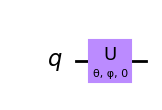

In [5]:
# Parameter value is not determined
ansatz_1q.draw('mpl')

In [1]:
# Substitue π/3 for theta and π/6 for phi
ansatz_1q.assign_parameters({theta: np.pi / 3., phi: np.pi / 6.}).draw('mpl')

NameError: name 'ansatz_1q' is not defined

Define a quantum circuit to measure the expectation values of $X, Y, Z$ for the state created by the variational form.

In [7]:
circuits = dict()

# Change the basis with H gate to measure <X>
circuits['X'] = ansatz_1q.copy()
circuits['X'].h(0)
circuits['X'].measure_all()

# Change the basis with Sdg and H gates to measure <Y>
circuits['Y'] = ansatz_1q.copy()
circuits['Y'].sdg(0)
circuits['Y'].h(0)
circuits['Y'].measure_all()

# No basis change to measure <Z>
circuits['Z'] = ansatz_1q.copy()
circuits['Z'].measure_all()

Define a function to calculate an expectation value from results obtained by running each circuit with the `run()` method of a backend.

In [8]:
backend = AerSimulator()

def circuit_expval(circuit, param_vals):
    bound_circuit = circuit.assign_parameters({theta: param_vals[0], phi: param_vals[1]})

    bound_circuit_tr = transpile(bound_circuit, backend=backend)
    # shots is defined outside the function
    job = backend.run(bound_circuit_tr, shots=shots)
    counts = job.result().get_counts()

    return (counts.get('0', 0) - counts.get('1', 0)) / shots

# Example：U(π/3, π/6, 0)|0>
shots = 10000
param_vals = [np.pi / 3., np.pi / 6.]
for pauli in ['X', 'Y', 'Z']:
    print(f'<{pauli}> = {circuit_expval(circuits[pauli], param_vals):.5f}')

<X> = 0.7496
<Y> = 0.4254
<Z> = 0.4894


Define objective function to be minimized.

In [9]:
def objective_function(param_vals):
    loss = 0.
    for pauli in ['X', 'Y', 'Z']:
        # target_state_1q is defined outside the funciton
        op = SparsePauliOp(pauli)
        target = target_state_1q.expectation_value(op).real
        current = circuit_expval(circuits[pauli], param_vals)
        loss += (target - current) ** 2

    return loss

# Function that is called every step of optimization. This stores the values of objective function into a list.
def callback_function(param_vals):
    # losses is defined outside the function
    losses.append(objective_function(param_vals))

Here a function that calculates the fidelity $|\langle \psi_0 | \psi(\theta, \phi) \rangle|^2$ between the target state and a state that the variational form with optimized parameters produces after optimization is defined. If the optimization is perfectly successful, the fidelity value becomes 1.

In [10]:
def fidelity(ansatz, param_vals, target_state):
    # Obtain the list of circuit parameters using circuit.parameters
    parameters = ansatz.parameters

    param_binding = dict(zip(parameters, param_vals))
    opt_ansatz = ansatz.assign_parameters(param_binding)

    # Statevector can be generated from a circuit as well by applying it to |0> state.
    circuit_state = Statevector(opt_ansatz)

    return np.square(np.abs(target_state.inner(circuit_state)))

Finally, the algorithm is executed with an instance of COBYLA optimizer.

In [11]:
# Maximum number of states for COBYLA
maxiter = 300
# Convergence condition for COBYLA (the smaller the better for approximation)
tol = 0.001
# Backend shot number
shots = 1000

# COBYLA instance
optimizer = COBYLA(maxiter=maxiter, tol=tol, callback=callback_function)

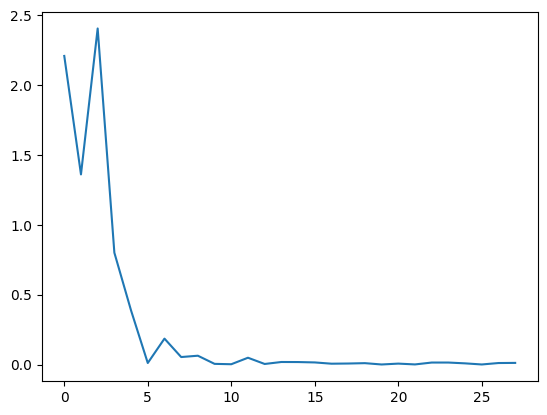

In [12]:
# Target state
target_state_1q = random_statevector(1)

# Choose theta within [0, π) and phi within [0, 2π) randomly
init = [rng.uniform(0., np.pi), rng.uniform(0., 2. * np.pi)]

# Perform optimization
losses = list()
min_result = optimizer.minimize(objective_function, x0=init)

plt.plot(losses);

In [13]:
fidelity(ansatz_1q, min_result.x, target_state_1q)

0.9979714941933505

#### Using Estimator

For Variational Quantum Algorithms including VQE, there is often the case that the expectation values of several observables are measured many times by replacing the parameters of a variational form with actual values. Therefore, it is recommended to use Estimator class, which can automate the process of repeated measurements with various error mitigation techniques. Here, the Estimator called BackendEstimator that allows to calculate using a specific backend is used.

In [14]:
# Create BackendEstimator instance
estimator = BackendEstimator(backend)

# Observable is defined using SparsePauliOp object
observables = [SparsePauliOp('X'), SparsePauliOp('Y'), SparsePauliOp('Z')]

param_vals = [np.pi / 3., np.pi / 6.]

# Give a variational form, observable and parameter values to run() method
# Since there are three observables, the number of ansatz_1q and param_values is also three.
job = estimator.run([ansatz_1q] * 3, observables, [param_vals] * 3, shots=10000)
result = job.result()
print(result.values)

[0.7416 0.4142 0.5012]


Define the objective funciton to use Estimator instance.

In [15]:
observables_1q = [SparsePauliOp('X'), SparsePauliOp('Y'), SparsePauliOp('Z')]

def objective_function_estimator(param_vals):
    target = np.array(list(target_state_1q.expectation_value(op).real for op in observables_1q))

    job = estimator.run([ansatz_1q] * len(observables_1q), observables_1q, [param_vals] * len(observables_1q), shots=shots)
    current = np.array(job.result().values)

    return np.sum(np.square(target - current))

def callback_function_estimator(param_vals):
    # losses is defined outside the function
    losses.append(objective_function_estimator(param_vals))

Optimize the above objective function.

In [16]:
# Maximum number of states for COBYLA
maxiter = 300
# Convergence condition for COBYLA (the smaller the better for approximation)
tol = 0.001
# Backend shot number
shots = 1000

# COBYLA instance
optimizer = COBYLA(maxiter=maxiter, tol=tol, callback=callback_function_estimator)

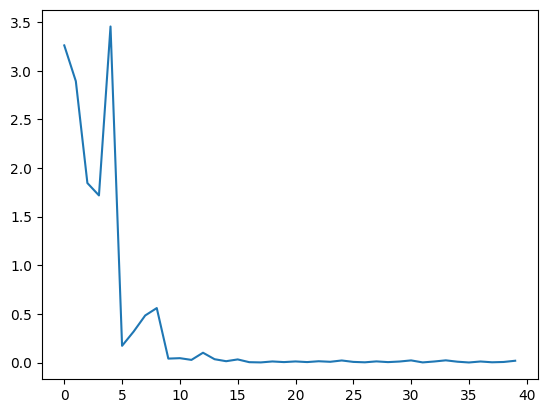

In [17]:
# Target state
target_state_1q = random_statevector(1)

# Choose theta within [0, π) and phi within [0, 2π) randomly
init = [rng.uniform(0., np.pi), rng.uniform(0., 2. * np.pi)]

# Perform optimization
losses = list()
min_result = optimizer.minimize(objective_function_estimator, x0=init)

plt.plot(losses);

In [18]:
fidelity(ansatz_1q, min_result.x, target_state_1q)

0.9985511038898157

### Introduction of Entanglement

Next, we consider a similar problem with 2 qubits. Here the expectation values of 15 observables that can determine a general 2-qubit state:

$$
\langle O_1 O_2 \rangle \quad (O_1, O_2 = I, X, Y, Z; O_1 O_2 \neq II)
$$

are measured with $I$ being an identity operator.

We can use the function `random_statevector` as it is. First, let us consider a circuit with $U$ gate on each of 2 qubits and define the objective function.

In [19]:
# Define ParameterVector object with 4 elements (since there are 4 parameters)
params = ParameterVector('params', 4)

ansatz_2q = QuantumCircuit(2)
ansatz_2q.u(params[0], params[1], 0., 0)
ansatz_2q.u(params[2], params[3], 0., 1)

In [20]:
paulis_1q = ['I', 'X', 'Y', 'Z']
paulis_2q = list(f'{op1}{op2}' for op1 in paulis_1q for op2 in paulis_1q if (op1, op2) != ('I', 'I'))
observables_2q = list(SparsePauliOp(pauli) for pauli in paulis_2q)


def objective_function_2q(param_vals):
    # target_state_2q is defined outside the function
    target = np.array(list(target_state_2q.expectation_value(op).real for op in observables_2q))

    job = estimator.run([ansatz_2q] * len(observables_2q), observables_2q, [param_vals] * len(observables_2q), shots=shots)
    current = np.array(job.result().values)

    return np.sum(np.square(target - current))

def callback_function_2q(param_vals):
    # losses is defined outside the functon
    losses.append(objective_function_2q(param_vals))

In [21]:
# Maximum number of states for COBYLA
maxiter = 300
# Convergence condition for COBYLA (the smaller the better for approximation)
tol = 0.001
# Backend shot number
shots = 1000

# COBYLA instance
optimizer = COBYLA(maxiter=maxiter, tol=tol, callback=callback_function_2q)

# Target state
target_state_2q = random_statevector(2)
#target_state_2q = Statevector(np.array([1., 0., 0., 1.], dtype=complex) / np.sqrt(2.))

# Initial values of parameters
init = rng.uniform(0., 2. * np.pi, size=4)

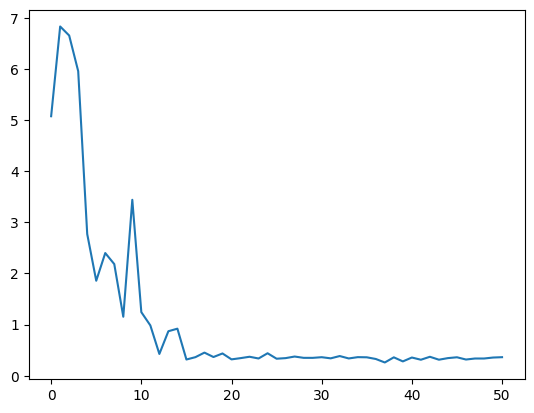

In [22]:
# Perform optimization
losses = list()
min_result = optimizer.minimize(objective_function_2q, x0=init)
plt.plot(losses);

In [23]:
fidelity(ansatz_2q, min_result.x, target_state_2q)

0.9583735027813598

It is rather obvious that the result is not as good as the single-qubit case. How can we improve this?

**Introduce entanglement into the variational form**

```python
ansatz_2q = QuantumCircuit(2)
ansatz_2q.u(params[0], params[1], 0., 0)
ansatz_2q.u(params[2], params[3], 0., 1)
ansatz_2q.cx(0, 1)
```

Please check what happens with this circuit.

For a most generic 2-qubit state, the 2 qubits are entangled so the introduction of 2-qubit gate will naturally help. If one wants to produce Bell states（See [Confirming the violation of the CHSH inequality](https://utokyo-icepp.github.io/qc-workbook/en/chsh_inequality.html#id14)), this is more clearly seen. It would be interesting to change the `target_state_2q` from

```python
target_state_2q = random_statevector(2)
```

to, e.g,

```python
target_state_2q = Statevector(np.array([1., 0., 0., 1.], dtype=complex) / np.sqrt(2.))
```

and try to approximate the state with and without 2-qubit entangling gate.

## Variational Quantum Eigensolver

Now we try to implement a simple example of VQE algorithm.

### VQE Implementation
What we consider here is to minimize the expectation value of a certain observable in VQE by updating circuit parameters using paramter shift rule.

The variational form consists of multiple layers of $R_YR_Z$ gates, and the observable is $ZXY$, a tensor-product of Pauli $Z, X, Y$ gates.

The expectation values obtained using VQE with three different optimizers are compared with the exact value obtained by diagonalizing the observable.

In [24]:
from qiskit_algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import CG, GradientDescent
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient

In [ ]:
# Ansats definition
num_qubits = 3   # number of qubits
num_layers = 2  # number of layers

ansatz = QuantumCircuit(num_qubits)

# Parameter list
theta = ParameterVector('θ')

# Add one element to the list and return the added list
def new_theta():
    theta.resize(len(theta) + 1)
    return theta[-1]

for _ in range(num_layers):
    for iq in range(num_qubits):
        ansatz.ry(new_theta(), iq)

    for iq in range(num_qubits):
        ansatz.rz(new_theta(), iq)

    #for iq in range(num_qubits - 1):
    #    ansatz.cx(iq, iq + 1)

ansatz.draw('mpl')

In [ ]:
# Observable to be measured
obs = SparsePauliOp('ZXY')

# Initial values of the parameters
init = rng.uniform(0., 2. * np.pi, size=len(theta))

# Object to calcualte the gradient of observable using Estimator class
grad = ParamShiftEstimatorGradient(estimator)

# VQE with conjugate gradient
optimizer_cg = CG(maxiter=200)
vqe_cg = VQE(estimator, ansatz, optimizer_cg, gradient=grad, initial_point=init)

# VQE with gradient descent
optimizer_gd = GradientDescent(maxiter=200)
vqe_gd = VQE(estimator, ansatz, optimizer_gd, gradient=grad, initial_point=init)

# VQE with COBYLA
optimizer_cobyla = COBYLA(maxiter=300)
vqe_cobyla = VQE(estimator, ansatz, optimizer_cobyla, initial_point=init)

# Solver with exact diagonalization
ee = NumPyMinimumEigensolver()

In [ ]:
result_vqe_cg = vqe_cg.compute_minimum_eigenvalue(obs)
result_vqe_gd = vqe_gd.compute_minimum_eigenvalue(obs)
result_vqe_cobyla = vqe_cobyla.compute_minimum_eigenvalue(obs)
result_ee = ee.compute_minimum_eigenvalue(obs)

In [ ]:
print('Result:')
print(f'  Exact      = {result_ee.eigenvalue}')
print(f'  VQE(COBYLA) = {result_vqe_cobyla.optimal_value}')
print(f'  VQE(CG)    = {result_vqe_cg.optimal_value}')
print(f'  VQE(GD)    = {result_vqe_gd.optimal_value}')

## Quantum Circuit Learning

## Simple Example
Let us consider the situation that we are given an input $\{x_i\}$ and an output $y_i=f(x_i)$ from a certain function $f$, and we want to (approximately) extract the function $f$ from the set of such data. This is a typical inverse problem. As an example, the function $f$ is taken to be $f(x)=x^3$ here.

### Preparation of Training Data

In [ ]:
random_seed = 0
rng = np.random.default_rng(random_seed)

# Number of qubits, layers of variational form, training datasets, etc.
nqubit = 3
nlayer = 5
x_min = -1.
x_max = 1.
num_x_train = 30
num_x_validation = 20

# Function f(x)
func_to_learn = lambda x: x ** 3

# Generate training dataset
x_train = rng.uniform(x_min, x_max, size=num_x_train)
y_train = func_to_learn(x_train)

# Add Gaussian noise to the output of the functon
mag_noise = 0.05
y_train_noise = y_train + rng.normal(0., mag_noise, size=num_x_train)

# Generate validation dataset
x_validation = rng.uniform(x_min, x_max, size=num_x_validation)
y_validation = func_to_learn(x_validation) + rng.normal(0., mag_noise, size=num_x_validation)

# Make the distribution of training data
x_list = np.arange(x_min, x_max, 0.02)
plt.plot(x_train, y_train_noise, "o", label='Training Data (w/ Noise)')
plt.plot(x_list, func_to_learn(x_list), label='Original Function')
plt.legend()

### State Preparation

In [ ]:
u_in = QuantumCircuit(nqubit, name='U_in')
x = Parameter('x')

for iq in range(nqubit):
    # parameter.arcsin() returns arcsin(v) when a value v is substituted for parameter
    u_in.ry(x.arcsin(), iq)
    # Similarly for arccos
    u_in.rz((x * x).arccos(), iq)

u_in.assign_parameters({x: x_train[0]}).draw('mpl')

### State Transformation with Variational Form

In [ ]:
u_out = QuantumCircuit(nqubit, name='U_out')

# Parameter list with length 0
theta = ParameterVector('θ', 0)

# Add one element to the list and retrun the last element
def new_theta():
    theta.resize(len(theta) + 1)
    return theta[-1]

for iq in range(nqubit):
    u_out.ry(new_theta(), iq)

for iq in range(nqubit):
    u_out.rz(new_theta(), iq)

for iq in range(nqubit):
    u_out.ry(new_theta(), iq)

for il in range(nlayer):
    for iq in range(nqubit):
        u_out.cz(iq, (iq + 1) % nqubit)

    for iq in range(nqubit):
        u_out.ry(new_theta(), iq)

    for iq in range(nqubit):
        u_out.rz(new_theta(), iq)

    for iq in range(nqubit):
        u_out.ry(new_theta(), iq)

print(f'{len(theta)} parameters')

theta_vals = rng.uniform(0., 2. * np.pi, size=len(theta))

u_out.assign_parameters(dict(zip(theta, theta_vals))).draw('mpl')

### Measurement and Model Output

In [ ]:
model = QuantumCircuit(nqubit, name='model')

model.compose(u_in, inplace=True)
model.compose(u_out, inplace=True)

assign_params = dict(zip(theta, theta_vals))
assign_params[x] = x_train[0]

model.assign_parameters(assign_params).draw('mpl')

In [ ]:
# Use Estimator class (not real backend)
estimator = Estimator()

# Calculate y value from the input x and parameter values
def yvals(param_vals, x_vals=x_train):
    circuits = list()
    for x_val in x_vals:
        # Variational circuit with real values only in x
        circuits.append(model.assign_parameters({x: x_val}))

    # Observable is IIZ (the rightmost bit is the first qubit)
    observable = SparsePauliOp('I' * (nqubit - 1) + 'Z')

    # shots is defined outside the function
    job = estimator.run(circuits, [observable] * len(circuits), [param_vals] * len(circuits), shots=shots)

    return np.array(job.result().values)

def objective_function(param_vals):
    return np.sum(np.square(y_train_noise - yvals(param_vals)))

def callback_function(param_vals):
    # losses is defined outside the function
    losses.append(objective_function(param_vals))

    if len(losses) % 10 == 0:
        print(f'COBYLA iteration {len(losses)}: cost={losses[-1]}')

In [ ]:
# Maximum number of states for COBYLA
maxiter = 100
# Convergence condition for COBYLA (the smaller the better for approximation)
tol = 0.01
# Backend shot number
shots = 1000

optimizer = COBYLA(maxiter=maxiter, tol=tol, callback=callback_function)

In [ ]:
initial_params = rng.uniform(0., 2. * np.pi, size=len(theta))

losses = list()
min_result = optimizer.minimize(objective_function, initial_params)
plt.plot(losses)

In [ ]:
x_list = np.linspace(x_min, x_max, 100)

y_pred = yvals(min_result.x, x_vals=x_list)

# Make a result plot
plt.plot(x_train, y_train_noise, "o", label='Training Data (w/ Noise)')
plt.plot(x_list, func_to_learn(x_list), label='Original Function')
plt.plot(x_list, np.array(y_pred), label='Predicted Function')
plt.legend();

### Run on quantum computer

You couldd try to run the task on quantum computer using Qiskit Runtime session, but **this may take a long time to finish**. We will skip this for now.

In [ ]:
# Use public IBM machine
#instance = 'ibm-q/open/main'
instance = 'ibm-q-utokyo/internal/icepp'  # For internal use

try:
    provider = IBMProvider(instance=instance)
except AccountNotFoundError:
    provider = IBMProvider(token='__paste_your_token_here__', instance=instance)

backend_list = provider.backends(filters=operational_backend(min_qubits=4))
backend = least_busy(backend_list)
print(f"least busy backend: {backend.name}")

In [ ]:
from qiskit_ibm_runtime import Estimator, Session
from qiskit_ibm_runtime import QiskitRuntimeService

#Initialize a QiskitRuntimeService object
service = QiskitRuntimeService()

#We will use the 127-qubit ibm_nazca backend
backend = service.get_backend(backend.name)

# create a Runtime session for efficient execution (optional)
session = Session(service=service, backend=backend)
estimator = Estimator(session=session)

In [ ]:
# Maximum number of states for COBYLA
maxiter = 50
# Convergence condition for COBYLA (the smaller the better for approximation)
tol = 0.01
# Backend shot number
shots = 1000

optimizer = COBYLA(maxiter=maxiter, tol=tol, callback=callback_function)

Uncomment the lines below when running on hardware. Note again that this will take a very long time to finish.

In [ ]:
initial_params = rng.uniform(0., 2. * np.pi, size=len(theta))

#losses = list()
#min_result = optimizer.minimize(objective_function, initial_params)
#plt.plot(losses)

In [ ]:
x_list = np.linspace(x_min, x_max, 100)

y_pred = yvals(min_result.x, x_vals=x_list)

# Make a result plot
plt.plot(x_train, y_train_noise, "o", label='Training Data (w/ Noise)')
plt.plot(x_list, func_to_learn(x_list), label='Original Function')
plt.plot(x_list, np.array(y_pred), label='Predicted Function')
plt.legend();